In [1]:
from mlputils import Linear
from mlputils import BatchNorm1D
from mlputils import Tanh
from mlputils import Embedding
from mlputils import FlattenConsecutive
from mlputils import Sequential

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

random.seed(42)

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [4]:
block_size = 8  # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    
    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size  # initialize with all dots
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # slide the window, by popping and appending
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [ ]:
n_embed = 24 # embedding vector dimensionality
n_hidden = 128 # neurons in hidden layer


model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


22397


In [6]:
# Optimization

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # Gradient
    # for layer in layers:
    #     layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 150000 else 0.01 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    

      0/ 200000: 3.3103
  10000/ 200000: 2.1017
  20000/ 200000: 1.9405
  30000/ 200000: 2.1202
  40000/ 200000: 1.9285
  50000/ 200000: 1.6779
  60000/ 200000: 2.0160
  70000/ 200000: 1.9200
  80000/ 200000: 2.3290
  90000/ 200000: 1.5511
 100000/ 200000: 1.9225
 110000/ 200000: 1.6414
 120000/ 200000: 1.7283
 130000/ 200000: 2.1395
 140000/ 200000: 1.9859
 150000/ 200000: 2.1053
 160000/ 200000: 1.9873
 170000/ 200000: 1.9437
 180000/ 200000: 1.7613
 190000/ 200000: 2.0088


In [7]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1D : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1D : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1D : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


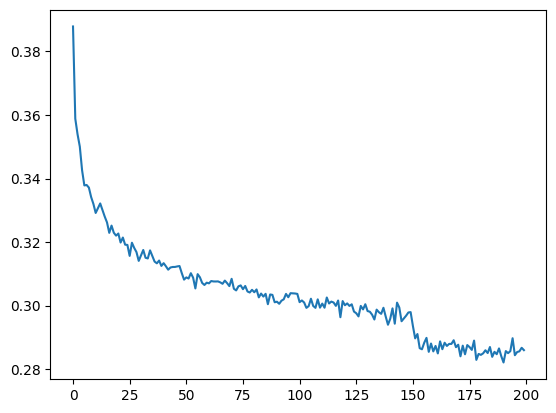

In [8]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [9]:
# put layers into eval mode

for layer in model.layers:
  layer.training = False

In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtest, Ytest),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())


split_loss('train')
split_loss('val')

train 1.9108473062515259
val 2.0203685760498047


In [11]:
# Sample from the model


for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))

      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

lemia.
renney.
rowen.
vivikto.
sikmar.
suvalynn.
anah.
manuel.
maeeleigh.
sadin.
shodvin.
caeria.
zyeliana.
tatie.
jersin.
fahith.
zukair.
chester.
mahamir.
kamyah.
